One way to find out what exactly a neural network learns is to look at the function of each neuron individually. Although there's no easy way to disentangle a single neuron from the rest of the network, we can try to figure out what kind of input is recognized by that neuron - and that gives us some insight into its role.

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In this notebook, we train a neural network on the digits dataset from scikit-learn, which contains 1797 8x8 images of handwritten digits. We then initialize the input with a random image, and instead of using gradient descent to optimize the weights to minimize the loss, we use it to optimize the input image to maximize the activation of a particular neuron. Visualizing this optimized image can then tell us something about what that neuron responds to.

In [2]:
digits = load_digits()

X_scaled = (digits.data - np.min(digits.data))/(np.max(digits.data) - np.min(digits.data))

# Convert X and y into PyTorch tensors and apply a one-hot encoding to y
X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.nn.functional.one_hot(torch.tensor(digits.target, dtype=torch.long)).float()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [42]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs):
        super().__init__()
        self.layer1 = torch.nn.Linear(n_inputs, n_hidden)
        self.layer2 = torch.nn.Linear(n_hidden, n_outputs)
        self.activation = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        return x
    
class ConvNet(torch.nn.Module):
    def __init__(self, n_hidden, n_outputs):
        super().__init__()
        self.conv2d = torch.nn.Conv2d(1, n_hidden, kernel_size=(8,1))
        self.flatten = torch.nn.Flatten()
        self.fc = torch.nn.Linear(128, n_outputs)
        
    def forward(self, x):
        x = self.conv2d(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x
    
    
model = NeuralNetwork(64, 16, 10)

model_cnn = ConvNet(16, 10)

loss_criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.001, momentum=0.9)

num_epochs = 20
for epoch in range(num_epochs):
    for i in range(len(X_train)):
        optimizer.zero_grad()
        y_pred = model_cnn(torch.reshape(X_train[i], (8,8)).unsqueeze(0).unsqueeze(0)) 
        loss = loss_criterion(y_pred[0], y_train[i])
        loss.backward()
        optimizer.step()

Now that we've trained the network, we take each of the 10 output neurons in turn and try to maximize its activation.

In [52]:
# Turn off weight updating during backprop
for param in model.parameters():
    param.requires_grad = False
    
# Set model to evaluation mode
model.eval()

learning_rate = 0.01
num_iterations = 2500

images = []

for k in range(10):
    input_tensor = torch.randn(1, 1, 8, 8, requires_grad=True)
    
    for i in range(num_iterations):
        output = model_cnn(input_tensor)
        output[0][k].backward()
        input_tensor.data += learning_rate * input_tensor.grad.data
        input_tensor.grad.zero_()
        
    img = input_tensor.detach().numpy().reshape((8, 8))
    img = (img - np.min(img))/(np.max(img) - np.min(img))*256

    images.append(img)

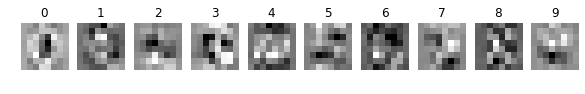

In [53]:
fig = plt.figure(figsize=(10, 1))

for i in range(len(images)):
    fig.add_subplot(1, 10, i+1)
    plt.imshow(images[i], cmap="gray")
    plt.axis('off')
    plt.title(i)

From the above images, it's clear that each output neuron responds most strongly to an image that looks at least vaguely like the digit that it predicts. We can see this for 0, 2, 3 and 5, and make out shapes in the other images that correspond to parts of the associated digits (for example, the optimized image for 8 looks like an X - that's what that neuron detects).